In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import netCDF4 as nc
import geojson
import json
import urllib
import os, re
# import folium
# from folium.plugins import MarkerCluster, FastMarkerCluster

In [2]:
url_base = 'http://opendap.tudelft.nl/thredds/dodsC/data2/zandmotor/morphology/sediment_composition/'
urls = ['sedimentsampling_sandmotor_oct2010.nc',
        'sedimentsampling_sandmotor_aug2012.nc',
        'sedimentsampling_nemo_feb2013.nc',
        'sedimentsampling_nemo_feb2013_malvern.nc',
        'sedimentsampling_sandmotor_oct2013.nc',
        'sedimentsampling_nemo_feb2014.nc',
        'sedimentsampling_nemo_oct2014.nc',
        'sedimentsampling_sandmotor_aug2015.nc']

In [19]:
urlpaths = [os.path.join(url_base, u) for u in urls ]

features = []
features_pt = []
for url in urlpaths:
    dataset = nc.Dataset(url)
    # get location of sampling
    lat = dataset['lat'][:].tolist()
    lon = dataset['lon'][:].tolist()
    # print(lat, lon)
    time = nc.num2date(dataset['time'][:],'seconds since 1970-01-01') # definition in the nc is wrong
    timeDT = list(map(str, nc.num2date(dataset['time'][:], units='seconds since 1970-01-01').tolist()))
    timeUX = [ int(it.timestamp()) for it in nc.num2date(dataset['time'][:], units='seconds since 1970-01-01')]
    
    # build geojson
    properties = {}
    depthvalues = []
    name = ['D10','D30','D50','D60','D90']
    #nameS = ['Sfines','Smedium','Scoarse']
    nameS = []
    dictsed_np = dict()
    dictsed = dict()
    for k in name+nameS:
        dictsed_np[k] = dataset[k][:]
        dictsed_np[k][np.isnan(dictsed_np[k])] = None #'NaN' #-999 # nodata
        dictsed[k] = dictsed_np[k].tolist()
    dictsed_np['depth'] = dataset['depth'][:]
    dictsed_np['depth'][np.isnan(dictsed_np['depth'])] = None #'NaN' #-999 # nodata
    dictsed['depth'] = dictsed_np['depth'].tolist()

    #properties = dictsed

    #properties['depth'] = depthvalues

    for ff in range(len(timeDT)):
        for kk in list(dictsed.keys()):
            properties[kk] = dictsed[kk][ff]
        properties['id'] = nc.chartostring(dataset['label'][ff],encoding='utf-8').tolist()
        properties['url'] = url
        properties['time'] = timeUX[ff]

        feature_pt = geojson.Feature(geometry=geojson.Point(coordinates=[lon[ff], lat[ff]]), properties=properties)
        features.append(feature_pt)
    #features.append(features_pt)


/home/giosans/.virtualenvs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater


In [20]:
feature_pt

{"geometry": {"coordinates": [4.216229588048768, 52.09187568004734], "type": "Point"}, "properties": {"D10": 124.043333333333, "D30": 172.2416666666665, "D50": 220.44, "D60": 324.3183333333335, "D90": 428.196666666667, "depth": -11.410415, "id": "11.5_344 ", "time": 1440367200, "url": "http://opendap.tudelft.nl/thredds/dodsC/data2/zandmotor/morphology/sediment_composition/sedimentsampling_sandmotor_aug2015.nc"}, "type": "Feature"}

In [21]:
featurecollection = geojson.FeatureCollection(features)

with open(r'../static/sediment_data.geojson', 'w') as f:
    json.dump(featurecollection, f)

In [22]:
#load the saved geojson
with open(r'../static/sediment_data.geojson', 'r') as f:
    data = json.load(f)

fcoord = []; fid = []; fD10 = []; fD30 = []; fD50 = []; fD60 = []; fD90 = []; fdepth = []; ftime = [];
for feat in data['features']:
    # feat['geometry']['type'] # type
    fid.append(feat['properties']['id']) # coordinates
    fcoord.append([feat['geometry']['coordinates'][1],feat['geometry']['coordinates'][0]]) # coordinates
    fD10.append(feat['properties']['D10']) # D10
    fD30.append(feat['properties']['D30']) # D30
    fD50.append(feat['properties']['D50']) # D50
    fD60.append(feat['properties']['D60']) # D60
    fD90.append(feat['properties']['D90']) # D90
    fdepth.append(feat['properties']['depth']) # depth
    ftime.append(feat['properties']['time']) # time


In [23]:
# get sed data from the list
def seddata(D10,D30,D50,D60,D90):
    x = [0, 10, 30, 50, 60, 90]
    y = [0,D10,D30,D50,D60,D90]
    return x, y

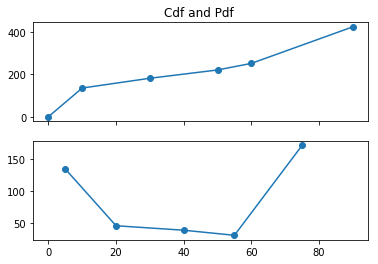

In [24]:
import random
row_i = random.randint(0,len(fid))

curvex,curvey = seddata(fD10[row_i],fD30[row_i],fD50[row_i],fD60[row_i],fD90[row_i])

# plot of sediment curve is missing. Addit!
f, axarr = plt.subplots(2, sharex=True)

axarr[0].plot(curvex,curvey,'-o')
axarr[0].set_title('Cdf and Pdf ')
axarr[1].plot(np.diff(curvex)/2.+curvex[:-1],np.diff(curvey),'-o') # to be changed..


In [100]:
np.diff(curvex)/2.+curvex[:-1]

array([  5.,  20.,  40.,  55.,  75.])